In [121]:
import pandas as pd
import os

train_data = pd.read_csv(os.getcwd()+'/data/BNP_data/train.csv')
test_data = pd.read_csv(os.getcwd()+'/data/BNP_data/test.csv')

# Fill NA values accordingly
from sklearn.base import TransformerMixin
import numpy as np

class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
train_data = DataFrameImputer().fit_transform(train_data)
test_data = DataFrameImputer().fit_transform(test_data)

# Convert string values to numeric
from sklearn import preprocessing

criteria = train_data.dtypes == object
object_columns = train_data[criteria.index[criteria]].columns

le = preprocessing.LabelEncoder()
for col in object_columns:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

# Cross-validation
from sklearn import cross_validation
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(train_data.drop('target', axis=1), train_data['target'], \
    test_size=0.33, random_state=5)

In [78]:
def find_outliers(column):
    upper_bd = column.mean() + 3*column.std()
    lower_bd = column.mean() - 3*column.std()
    return column[column >= lower_bd]

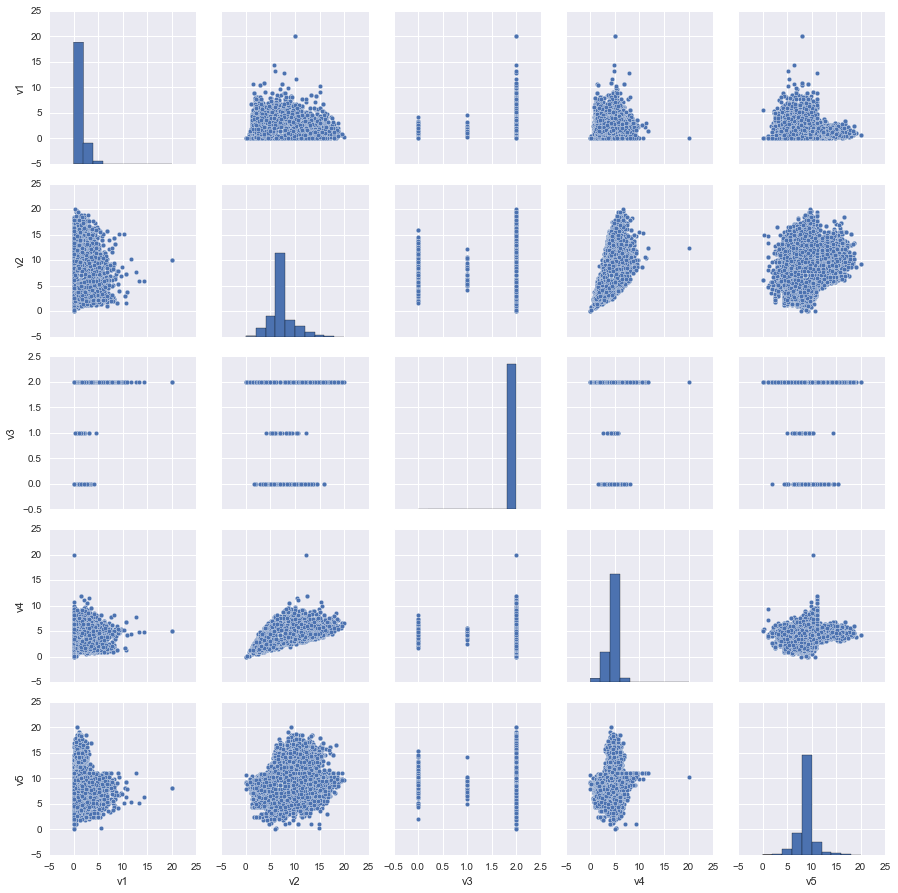

In [79]:
%matplotlib inline

import seaborn as sns

sns.pairplot(X_train[['v1', 'v2', 'v3', 'v4', 'v5']])

In [131]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, copy=True, whiten=True)

In [126]:
def logloss(y, p):
    N = len(y)
    if len(p) != N:
        return print('Vectors of unequal length')
    
    p = np.array([max(min(p_i, 1-10**(-15)), 10**(-15)) for p_i in p])
    
    summand = y*np.log(p)+(1-y)*np.log(1-p)
    ll = -sum(summand)/N
    return ll

In [127]:
import xgboost as xgb

def xgb_optimizer(params):
    eta = params[0]
    max_depth = int(params[1])
    num_rounds = int(params[2])
    
    xgb_params = {'objective': 'reg:linear', 'eta': eta, 'max_depth': max_depth, 'seed': 42, 'eval_metric': 'logloss'}

    # Format the matrices for xgb
    dtrain = xgb.DMatrix(pca.fit_transform(X_train), label = Y_train)
    dtest = xgb.DMatrix(pca.transform(X_test), label = Y_test)
    gbdt = xgb.train(xgb_params, dtrain, num_rounds)

    # Get the predicted values for the test data
    Y_test_pred = gbdt.predict(dtest)
    Y_test_pred[Y_test_pred > 1] = 1
    Y_test_pred[Y_test_pred < 0] = 0
    
    # Get the predicted values for the test data
    Y_train_pred = gbdt.predict(dtrain)
    Y_train_pred[Y_train_pred > 1] = 1
    Y_train_pred[Y_train_pred < 0] = 0
    
    return [logloss(Y_test, Y_test_pred), logloss(Y_train, Y_train_pred)]

In [128]:
pca_logloss = xgb_optimizer([0.01, 6, 400])

In [132]:
pca_logloss_whitened = xgb_optimizer([0.01, 6, 400])

In [135]:
print('pca logloss: ', pca_logloss)
print('pca logloss whitened: ', pca_logloss_whitened)
pca_logloss_whitened[1] - pca_logloss[1]

pca logloss:  [0.52743868454502807, 0.51870624669833909]
pca logloss whitened:  [0.52733661869670856, 0.51870387802019058]


-2.36867814851216e-06

In [136]:
X_train_pca_df = pd.DataFrame(pca.fit_transform(X_train))

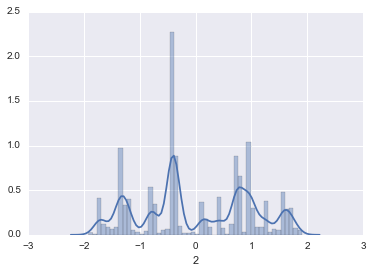

In [142]:
sns.distplot(X_train_pca_df.iloc[:,2])